In [1]:
import numpy as np
import pandas as pd
import matplotlib

from matplotlib import pyplot as plt
import seaborn as sns

import plotly as ply

import tqdm
import gc
import sys
import os

import scipy as sp

import json

%cd /data/lyna/Milestone_Error_Analysis_Testing
import analysis_functions

/data/lyna/Milestone_Error_Analysis_Testing


In [80]:
def potFun(x):
    return(0.1*((1/2000)*(x)**6-(x)**2))
def potGradFun(x):
    return(0.1*((6.0/2000)*(x)**5-2.0*(x)))

In [21]:
# Run brute-force DB 
diffCoef=.0282*310.15/298.15 #Approximate scaling to body temperature 
bd_Sim=analysis_functions.Simple_1D_BD_Sim(potGradFun)
bd_Sim.set_parameters(dict(
    diffusionConstant=diffCoef,
    vmax=15.0,
    trajectorySnapshotRate=10,
    verbose=True,
    timestep=0.5
))

nsteps=1000000 #2000k steps = 0.5 us
bd_Sim.set_x0(-6.)
trajData=bd_Sim.run_sim(
    nsteps=nsteps,
    giveVelocities=True,
    pbar=tqdm.tqdm_notebook(total=nsteps))


nsteps=2000000 #2000k steps = 1 us
bd_Sim.set_x0(6.)
trajData2=bd_Sim.run_sim(
    nsteps=nsteps,
    giveVelocities=True,
    pbar=tqdm.tqdm_notebook(total=nsteps))


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


2000000


binEdges [-8. -6. -4. -2.  0.  2.  4.  6.  8.] binCenters [-7. -5. -3. -1.  1.  3.  5.  7.]
normalized histogram [0.03276 0.32111 0.11549 0.03474 0.03446 0.11362 0.31535 0.03247]
pmf [ 1.40588191 -0.          0.62983878  1.36973762  1.37472196  0.63989329
  0.01114851  1.41135846]


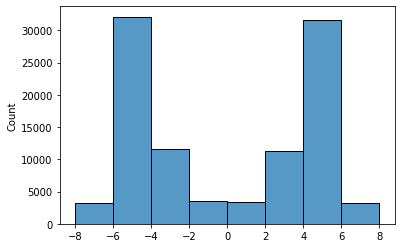

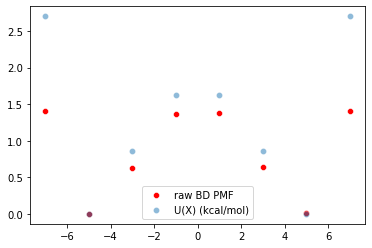

In [78]:
# Plot brute-force BD data and PMF
binEdges=np.linspace(-8,8,9)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
print("binEdges", binEdges, "binCenters",binCenters)

histogram=np.histogram( a=trajData['trajectory'],bins=binEdges)
normHist=histogram[0]/np.sum(histogram[0])
print("normalized histogram", normHist)
print("pmf", -kbT*np.log((normHist)/np.max(normHist)))

sns.histplot(trajData['trajectory'],bins=binEdges)
plt.show()
sns.scatterplot(x=binCenters, y=-kbT*np.log((normHist)/np.max(normHist)), color='r', label="raw BD PMF")
sns.scatterplot(x=binCenters,y=potFun(binCenters)-np.min(potFun(binCenters)),label='U(X) (kcal/mol)', alpha=0.5)
plt.show()

In [119]:


def gen_flat_bottom_harmonic_window_potFun(potFun,win_lhs,win_rhs,kval):
    return(
        lambda x: potFun(x)+.5*kval * ( (x<win_lhs)*(win_lhs-x)**2 + (x>win_rhs)*(win_rhs-x)**2 )
    )
def gen_flat_bottom_harmonic_window_potGradFun(potGradFun,win_lhs,win_rhs,kval):
    return(
        lambda x: potGradFun(x)-kval * ( (x<win_lhs)*(win_lhs-x) + (x>win_rhs)*(win_rhs-x) )
    )



def only_flat_bottom_harmonic_window_potFun(potFun,win_lhs,win_rhs,kval):
    return(
        lambda x: .5*kval * ( (x<win_lhs)*(win_lhs-x)**2 + (x>win_rhs)*(win_rhs-x)**2 )
    )
def only_flat_bottom_harmonic_window_potGradFun(potGradFun,win_lhs,win_rhs,kval):
    return(
        lambda x: -kval * ( (x<win_lhs)*(win_lhs-x) + (x>win_rhs)*(win_rhs-x) )
    )


In [123]:
# Setup milestone potential

binEdges=np.linspace(-8,8,9)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
print("binEdges", binEdges, "binCenters",binCenters)

symm_window_edges=binEdges
symm_window_lhs=symm_window_edges[:-1]
symm_window_rhs=symm_window_edges[1:]
symm_window_centers=binCenters
symm_window_kVals=np.array([100.]*len(symm_window_centers)) # force constant kVal=100
print(symm_window_centers)

symm_window_potFuns=[
    gen_flat_bottom_harmonic_window_potFun(potFun,wlhs,wrhs,wk) \
    for wlhs,wrhs,wk in np.array([
        symm_window_lhs,
        symm_window_rhs,
        symm_window_kVals
    ]).T
]

symm_window_potGradFuns=[
    gen_flat_bottom_harmonic_window_potGradFun(potGradFun,wlhs,wrhs,wk) \
    for wlhs,wrhs,wk in np.array([
        symm_window_lhs,
        symm_window_rhs,
        symm_window_kVals
    ]).T
]



binEdges [-8. -6. -4. -2.  0.  2.  4.  6.  8.] binCenters [-7. -5. -3. -1.  1.  3.  5.  7.]
[-7. -5. -3. -1.  1.  3.  5.  7.]


win 0
win 1
win 2
win 3
win 4
win 5
win 6
win 7


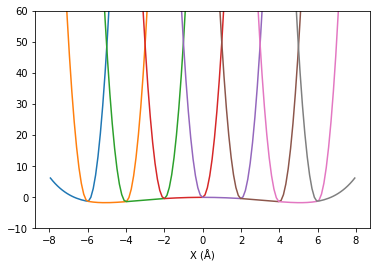

In [124]:
# plot milestone potential before running

winPot=[]
winPotGrad=[]
for win in np.arange(0,len(symm_window_centers)):
    print("win",win)
    winPot=symm_window_potFuns[win]
    winPotGrad=symm_window_potGradFuns[win]
    
    binEdges=np.linspace(-8,8,130)
    binCenters=(binEdges[:-1]+binEdges[1:])/2.
    xgrid=binCenters

    sns.lineplot(
        x=xgrid,
        y=winPot(xgrid),
        #label='symm_win_%02g_U(x)'%win
    )
    

plt.xlabel('X (Å)')
plt.ylim(-10,60)
plt.show()

kbT 0.6159191312499999
symm_window_centers [-7. -5. -3. -1.  1.  3.  5.  7.]


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


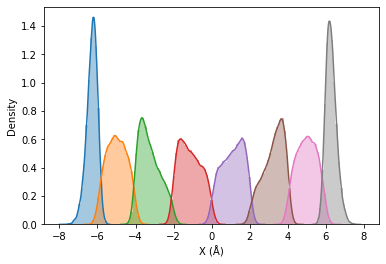

In [127]:
# Run milestoning

diffCoef=.0282*310.15/298.15
kb=0.001985875
Tsim=310.15
kbT=kb*Tsim
print("kbT",kbT, )
print("symm_window_centers",symm_window_centers)

symm_win_sim_data=[]
for iWin,winCenter in enumerate(symm_window_centers):
    win_potGradFun=symm_window_potGradFuns[iWin]
    bd_Sim=analysis_functions.Simple_1D_BD_Sim(win_potGradFun)
    bd_Sim.set_parameters(dict(
        diffusionConstant=diffCoef,
        vmax=15.0,
        trajectorySnapshotRate=10,
        verbose=True,
        timestep=0.5
    ))
    bd_Sim.set_x0(winCenter)

    nsteps=500000 #500k steps x8 windows x 0.5 fs= 2 us, sufficeint to converge brute-force BD
    symm_win_sim_data.append(bd_Sim.run_sim(nsteps=nsteps,giveVelocities=True,
        pbar=tqdm.tqdm_notebook(total=nsteps)))
    trajData=symm_win_sim_data[iWin]
    binEdges=np.linspace(-8,8,130)
    binCenters=(binEdges[:-1]+binEdges[1:])/2.
    xgrid=binCenters
    sns.distplot(trajData['trajectory'],bins=binEdges, color=None)

plt.xlabel('X (Å)')
plt.show()

In [95]:
# Save milestoning data

for iWin,winData in enumerate(symm_win_sim_data):
    stepsPerWindow=(len(winData['trajectory']))
print(stepsPerWindow)

milestone_data_table=pd.DataFrame({
    'Window':(np.array([[iWin]*len(winData['trajectory']) for iWin,winData in enumerate(symm_win_sim_data)])).flatten(),
    'X':(np.array([winData['trajectory'] for winData in symm_win_sim_data])).flatten(),
    "WindowCenter":((np.array([[winCenter]*stepsPerWindow for iWin,winCenter in enumerate(symm_window_centers)])).flatten()),
    #"WindowLeft":((np.array([[winCenter]*stepsPerWindow for iWin,winCenter in enumerate(symm_window_centers)])-1.5).flatten()),
    #"WindowRight":((np.array([[winCenter]*stepsPerWindow for iWin,winCenter in enumerate(symm_window_centers)])+1.5).flatten()),
})
milestone_data_table['X_Ind']=milestone_data_table['X'].map(lambda x: np.argmin(np.abs(x-symm_window_centers)))
milestone_data_table
milestone_data_table.to_csv('data_window.csv',index=False)

symm_window_data=pd.DataFrame({
    'Window':np.arange(len(symm_window_centers)),
    'LHS_Edge':symm_window_lhs,
    'Center':symm_window_centers,
    'RHS_Edge':symm_window_rhs
})
print('saving window setup data')
display(symm_window_data.head())
symm_window_data.to_csv('setup_windows.csv',index=False)

50000
saving window setup data


,Window,LHS_Edge,Center,RHS_Edge
0,0,-8.0,-7.0,-6.0
1,1,-6.0,-5.0,-4.0
2,2,-4.0,-3.0,-2.0
3,3,-2.0,-1.0,0.0
4,4,0.0,1.0,2.0


In [96]:
# Compute milestoning PMF

# add a frame column for each window
milestoneSimulationsData=milestone_data_table
print(milestoneSimulationsData.head())

tempFrames=[]
with tqdm.tqdm_notebook(milestoneSimulationsData.groupby(['Window'])) as pbar:
    for group in pbar:
        groupName,groupData=group
        tempFrame=groupData.copy()
        tempFrame['Frame']=np.arange(len(tempFrame))
        tempFrame['Replica']=0
        tempFrame=tempFrame[['Replica','Window','Frame','X','X_Ind']]
        tempFrames.append(tempFrame.copy())
        gc.collect()
milestoneSimulationsData=pd.concat(tempFrames)
milestoneSimulationsData

   Window         X  WindowCenter  X_Ind
0       0 -7.000000          -7.0      0
1       0 -5.962580          -7.0      1
2       0 -6.034008          -7.0      0
3       0 -6.106564          -7.0      0
4       0 -6.019001          -7.0      0


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


,Replica,Window,Frame,X,X_Ind
0,0,0,0,-7.000000,0
1,0,0,1,-5.962580,1
2,0,0,2,-6.034008,0
3,0,0,3,-6.106564,0
4,0,0,4,-6.019001,0
...,...,...,...,...,...
399995,0,7,49995,6.285861,7
399996,0,7,49996,6.457048,7
399997,0,7,49997,6.594993,7
399998,0,7,49998,6.477957,7


In [97]:
milestoneData=analysis_functions.add_indexed_milestoning_analysis_columns(
    milestoneSimulationsData,
    windowColumn='Window',xIndexColumn='X_Ind',frameCol='Frame',
    repColumn=None,groupingColumn=None,verbose=True,
    verboseLevel=0
)
milestoneData["X"]=milestoneSimulationsData.X
milestoneData

/data/lyna/Milestone_Error_Analysis_Testing/analysis_functions.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simData[groupingCol]=0
/data/lyna/Milestone_Error_Analysis_Testing/analysis_functions.py:436: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simData[repCol]=0


--- --- --- Grouping Name: 0 --- --- ---
	--- --- Window Name: 0 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 1 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 2 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 3 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 4 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 5 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 6 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 7 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
--- --- --- ------ --- --- ---


,Window,X_Ind,Group,Rep,Frame,Escape_Vector,Reentry_Vector,X
0,0,0,0,0,0,0,-1,-7.000000
1,0,1,0,0,1,1,-1,-5.962580
2,0,0,0,0,2,0,1,-6.034008
3,0,0,0,0,3,0,1,-6.106564
4,0,0,0,0,4,0,1,-6.019001
...,...,...,...,...,...,...,...,...
399995,7,7,0,0,49995,7,6,6.285861
399996,7,7,0,0,49996,7,6,6.457048
399997,7,7,0,0,49997,7,6,6.594993
399998,7,7,0,0,49998,7,6,6.477957


In [98]:
#################### pi_vector and PMF ################

kb=0.001985875 #kcal/mol
simTemp=310.15
kbT=kb*simTemp

analysisFrame=milestoneData
binSet=np.sort(np.unique(np.concatenate([
    analysisFrame['Window'].unique(),
    analysisFrame['X_Ind'].unique()
])))
print("binSet",binSet)

testEscapeData=analysis_functions.compute_analysis_group_pi_vector(
    groupDataFrame=analysisFrame,windowColumn='Window',binSet=binSet,
    giveEscapeMat=True,giveCounts=True,giveBins=True,giveBinMap=True,
    giveCountsMat=True)
print('testEscapeData:',testEscapeData)

# escapeMat is the number of escape per frame, kij and kji, row sum must be 1


binSet [0 1 2 3 4 5 6 7]
testEscapeData: {'piVec': array([0.03781289, 0.30474158, 0.11739567, 0.03589485, 0.03617914,
       0.11869726, 0.31109044, 0.03818816]), 'escapeMat': <8x8 sparse matrix of type '<class 'numpy.float64'>'
	with 22 stored elements in List of Lists format>, 'counts': array([42394, 47914, 46343, 46680, 46602, 46324, 47913, 42366]), 'bins': array([0, 1, 2, 3, 4, 5, 6, 7]), 'binMap': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}, 'binSetMap': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}, 'countsMat': <8x8 sparse matrix of type '<class 'numpy.float64'>'
	with 22 stored elements in List of Lists format>}


pmf [2.01719991 0.73189125 1.31942518 2.04926232 2.04440347 1.31263393
 0.71919129 2.01111745]
window center [-7. -5. -3. -1.  1.  3.  5.  7.]


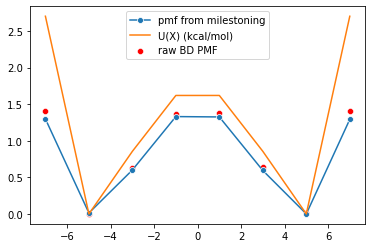

In [102]:
piVec=testEscapeData['piVec']
#sns.lineplot(np.arange(len(piVec)),piVec, marker='o', color='g', label="piVec")
pmfVec=-kbT*np.log(testEscapeData['piVec'])
print("pmf", pmfVec)
pmfVec=pmfVec-np.min(pmfVec)
xgrid=symm_window_centers
print("window center",xgrid)
sns.lineplot(
    x=xgrid,
    y=pmfVec, marker='o',label="pmf from milestoning")

sns.lineplot(
    x=xgrid,
    y=potFun(xgrid)-np.min(potFun(xgrid)),
    label='U(X) (kcal/mol)'
)

sns.scatterplot(x=xgrid, y=-kbT*np.log((normHist)/np.max(normHist)), color='r', label="raw BD PMF")

plt.show()